###Acquire the dataset from kaggle. 
Know how to download data from kaggle: https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

Visit the dataset: https://www.kaggle.com/hooong/ngafid-mc-20210917?select=NGAFID_MC_C37.csv

In [15]:
# ! pip install kaggle

In [16]:
# ! mkdir ~/.kaggle

In [17]:
# ! cp /kaggle.json ~/.kaggle/

In [18]:
# ! chmod 600 ~/.kaggle/kaggle.json

In [19]:
# !kaggle datasets download -d hooong/ngafid-mc-20210917

In [20]:
# !unzip /content/ngafid-mc-20210917.zip

In [21]:
# from google.colab import drive
# drive.mount('/content/drive')

### SETUP

In [22]:
!pip install gdown

In [23]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
import gc 
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
import matplotlib as plt
import seaborn as sns
import shutil
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions


gc.collect() 

pd.options.mode.chained_assignment = None
tf.config.run_functions_eagerly(False)

In [24]:
#TPU

import os
assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

TPU address is grpc://10.27.165.90:8470
Running on TPU  grpc://10.27.165.90:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.27.165.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.27.165.90:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# HYPER

In [25]:
BATCH_SIZE = 32
SHAPE = (4096, 23)
BLOCK_SHAPE = (128, 23)
EPOCHS = 30
VARIABLES = 23
NFOLD = 5 # if you change this you will need to re split the data 
STEPS_PER_EPOCH = 200
DATASET = 'C37' #C28 or C37

# READ DATA

In [26]:
import gdown

if DATASET == 'C28':
    url = 'https://drive.google.com/uc?id=1R5q2s-QavuI6DKj9z2rNxQPIOrbJlwUM'
elif DATASET == 'C37':
    url = 'https://drive.google.com/uc?id=1RkEZnddzlwpAG5GCht0HBWBBIcvHfYlT'
else: 
    raise KeyError('Invalid DATASET Hyper Parameter')

output = 'ds.csv.gz'
gdown.download(url, output, quiet=False)
!yes | gzip -d ds.csv.gz 

Downloading...
From: https://drive.google.com/uc?id=1RkEZnddzlwpAG5GCht0HBWBBIcvHfYlT
To: /content/ds.csv.gz
100%|██████████| 401M/401M [00:03<00:00, 110MB/s]


In [27]:
#Data before pre-processing

filename = 'ds.csv'
#Testing - Just read the first 100 rows in the file
df_test = pd.read_csv(filename, nrows=100)

#change the data type of the input dataset
float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float16 for c in float_cols}

df = pd.read_csv(filename, dtype=float32_cols, engine='c')
df['id'] = df.id.astype('int32')
df = df.dropna()
df.head(5)

,volt1,volt2,amp1,amp2,FQtyL,FQtyR,E1 FFlow,E1 OilT,E1 OilP,E1 RPM,E1 CHT1,E1 CHT2,E1 CHT3,E1 CHT4,E1 EGT1,E1 EGT2,E1 EGT3,E1 EGT4,OAT,IAS,VSpd,NormAc,AltMSL,id,plane_id,split,date_diff,before_after
0,27.90625,27.90625,7.898438,0.700195,24.0,24.0,2.089844,129.250,61.15625,1191.0,157.250,166.000,170.750,181.750,1081.0,1156.0,1112.0,1255.0,7.199219,0.0,15.742188,-0.020004,822.5,2,18,4,-2,1
1,27.90625,27.90625,7.898438,0.600098,24.0,24.0,2.130859,129.250,61.18750,1192.0,157.500,166.125,170.875,181.875,1082.0,1158.0,1114.0,1257.0,7.199219,0.0,11.132812,-0.000000,822.5,2,18,4,-2,1
3,27.90625,27.90625,7.800781,0.600098,24.0,24.0,2.119141,129.250,61.15625,1190.0,158.500,166.875,171.875,182.750,1094.0,1173.0,1125.0,1267.0,7.199219,0.0,-30.640625,-0.029999,824.5,2,18,4,-2,1
4,27.90625,27.90625,7.699219,0.600098,24.0,24.0,2.080078,129.125,61.25000,1197.0,159.000,167.250,172.375,183.125,1098.0,1178.0,1129.0,1271.0,7.199219,0.0,-23.953125,-0.020004,825.0,2,18,4,-2,1
5,27.90625,27.90625,7.601562,0.600098,24.0,24.0,2.060547,129.125,61.12500,1190.0,159.625,167.750,172.875,183.500,1101.0,1183.0,1133.0,1277.0,7.000000,0.0,-6.941406,-0.010002,824.5,2,18,4,-2,1


In [28]:
# drop the duplicate items, check the distribution
sources = df[['id', 'plane_id', 'split', 'date_diff', 'before_after']].drop_duplicates()

sources.loc[: , ['split', 'before_after', 'id']].groupby(['split', 'before_after']).count()

id
split before_after     
0     0             318
      1             224
1     0             246
      1             171
2     0             323
      1             252
3     0             256
      1             162
4     0             270
      1             167

In [29]:
# data preprocessing, MinMaxScaler
input_columns = ['volt1',
 'volt2',
 'amp1',
 'amp2',
 'FQtyL',
 'FQtyR',
 'E1 FFlow',
 'E1 OilT',
 'E1 OilP',
 'E1 RPM',
 'E1 CHT1',
 'E1 CHT2',
 'E1 CHT3',
 'E1 CHT4',
 'E1 EGT1',
 'E1 EGT2',
 'E1 EGT3',
 'E1 EGT4',
 'OAT',
 'IAS',
 'VSpd',
 'NormAc',
 'AltMSL']


preprocess = preprocessing.MinMaxScaler()
preprocess.fit(df.loc[:, input_columns].sample(100000, random_state = 0 ))

org_value = df.loc[:, input_columns].values
res = preprocess.transform(org_value)

for i, col in tqdm(enumerate(input_columns)):
    df.loc[:, col] = res[:, i]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


0it [00:00, ?it/s]

In [30]:
#check the data after pre-processing
df.head()

,volt1,volt2,amp1,amp2,FQtyL,FQtyR,E1 FFlow,E1 OilT,E1 OilP,E1 RPM,E1 CHT1,E1 CHT2,E1 CHT3,E1 CHT4,E1 EGT1,E1 EGT2,E1 EGT3,E1 EGT4,OAT,IAS,VSpd,NormAc,AltMSL,id,plane_id,split,date_diff,before_after
0,0.832031,0.828125,0.481201,0.599609,1.0,1.0,0.124451,0.567871,0.690918,0.419922,0.230225,0.306641,0.439697,0.293701,0.606445,0.654297,0.662109,0.768555,0.569336,0.006947,0.582520,0.316895,0.030823,2,18,4,-2,1
1,0.832031,0.828125,0.481201,0.577637,1.0,1.0,0.126831,0.567871,0.691406,0.420410,0.230713,0.307129,0.439941,0.293945,0.606445,0.655273,0.663086,0.769531,0.569336,0.006947,0.582031,0.326904,0.030823,2,18,4,-2,1
3,0.832031,0.828125,0.479492,0.577637,1.0,1.0,0.126221,0.567871,0.690918,0.419678,0.232666,0.309082,0.441895,0.295654,0.613281,0.663086,0.669922,0.775879,0.569336,0.006947,0.578125,0.312012,0.030945,2,18,4,-2,1
4,0.832031,0.828125,0.478027,0.577637,1.0,1.0,0.123840,0.566895,0.691895,0.422119,0.233887,0.310059,0.442871,0.296387,0.615234,0.665527,0.672363,0.778320,0.569336,0.006947,0.578613,0.316895,0.031006,2,18,4,-2,1
5,0.832031,0.828125,0.476318,0.577637,1.0,1.0,0.122681,0.566895,0.690430,0.419678,0.235107,0.311035,0.443848,0.297119,0.616211,0.667969,0.674805,0.781738,0.566406,0.006947,0.580566,0.322021,0.030945,2,18,4,-2,1


In [31]:
def get_slice_random_segment(x, y):
  """
  Parameter: x -> dataset ,y-> target label
  Return: x -> tensor(shape = (128,23)), y -> initial value
  """
  start = tf.random.uniform(shape=[], minval=0, maxval=4096-BLOCK_SHAPE[0], dtype=tf.int64)
  x = x[start: start + BLOCK_SHAPE[0]]
  x = tf.reshape(x, (BLOCK_SHAPE))
  return x, y 
    
def get_mse(model, df):
    """ Get loss value: the mean squared error value
    Parameter: model -> model being trained, df -> testing or validation dataset
    Return: mse value
    """ 
    
    targets = [example[1] for example in df]
    targets = tf.reshape(targets, (416,1)) 
    y_pred_1 = model.predict(df, verbose = True)
    mse_1 = tfk.losses.MSE(targets, y_pred_1).numpy()
    return mse_1.flatten()

In [32]:
def get_dataset(df): 
    """
    Parameter: df --> the dataset you want to acquire part of data
    """
    ids = df.id.unique()

    sensor_datas = []
    afters = [] 

    for id in tqdm(ids): 
        sensor_data = df[df.id == id].iloc[-SHAPE[0]:, :23].values

        sensor_data = np.pad(sensor_data, [[0, SHAPE[0]- len(sensor_data)], [0,0]])

        sensor_data = tf.convert_to_tensor(sensor_data, dtype = tf.float32) 

        after = df[df.id == id]['before_after'].iloc[0]

        sensor_datas.append(sensor_data)
        afters.append(after)


    sensor_datas = tf.stack(sensor_datas)
    afters = np.stack(afters)

    ds = tf.data.Dataset.from_tensor_slices( (sensor_datas, afters))
    
    return ds

def fix_type(x, y):
    """Align the data type
    """
    return tf.cast(x, tf.float32), tf.cast(y, tf.float32)

def prepare_for_training(ds, shuffle = False, repeat = False, predict= True):
    
    ds = ds.map(fix_type)
    ds = ds.map(get_slice_random_segment)

    ds = ds.shuffle(512) if shuffle else ds 
    ds = ds.repeat() if repeat else ds 
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)

    if not predict: 
        ds = ds.map(lambda x, y : (x, x) ) 
    else: 
        ds = ds.map(lambda x, y : (x, tf.reshape(y, (-1, 1))) )
         
    return ds 

In [33]:
def get_train_and_val_for_fold(folded_datasets, fold):
    """
    Get the dataset for training
    Parameter: folded_dataset: prepared dataset, fold: see which fold you want, from 1 to 5
    Return: training ds, validation ds, m
    """
    predict = True

    train = []
    for i in range(NFOLD-1): 
        if i == fold:
            val_ds = folded_datasets[i][0].concatenate(folded_datasets[i][1])
        else: 
            train.append(folded_datasets[i][0])
    
    test_ds = folded_datasets[4][0].concatenate(folded_datasets[4][1])
    
    train_ds = None
    for ds in train: 
        train_ds = ds if train_ds is None else train_ds.concatenate(ds)

    test_ds = prepare_for_training(test_ds, shuffle=False)
    train_ds = prepare_for_training(train_ds, shuffle=True, repeat = True)
    val_ds = prepare_for_training(val_ds, shuffle=False)
    
    return train_ds, val_ds, test_ds

In [34]:
#get the foled_dataset by split and before_after
folded_datasets = []

for i in range(NFOLD):
    after = get_dataset(df[(df.split == i) & (df.before_after == 1)])
    before = get_dataset(df[(df.split == i) & (df.before_after == 0)])
    folded_datasets.append((after, before))


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/318 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/323 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

# MODEL

In [35]:
#LSTM
def get_rnn_model_final():
    with strategy.scope():
      model = tf.keras.Sequential([
                              tf.keras.Input(shape= BLOCK_SHAPE),
                              tfkl.LSTM(64, return_sequences=True), 
                              tfkl.LSTM(64, return_sequences=True),
                              tfkl.LSTM(64, return_sequences=True),
                              tfkl.Dropout(0.5),
                              # tfkl.RepeatVector(OUTPUT_SEQ_LEN), 
                              tfkl.LSTM(64, return_sequences=True),
                              tf.keras.layers.GlobalAveragePooling1D(),
                              tfkl.Dense(1, activation = 'sigmoid')

      ])

      model.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6),
                    metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.AUC(curve = 'ROC')], 
                    loss = tfk.losses.MeanSquaredError(reduction= tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
                    )

    return model 

In [36]:
#CNN
def get_cnn_model_final():
    with strategy.scope():
      model = tf.keras.Sequential([
                            tf.keras.Input(shape  = BLOCK_SHAPE),
                                tfkl.Conv1D(128, 7, 1, activation= 'relu'),
                                tfkl.Conv1D(128, 7, 1, activation= 'relu'),
                                tfkl.Conv1D(128, 7, 1, activation= 'relu'),
                                tf.keras.layers.GlobalAveragePooling1D(),
                                tfkl.Dense(1, activation='sigmoid')

      ])
      model.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6),
                    metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.AUC(curve = 'PR')], 
                    loss = tfk.losses.MeanSquaredError(reduction= tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
                    )
    return model 

# Train the model

In [41]:
df_rnn_result = {}
df_cnn_result = {}
for i in tqdm(range(NFOLD-1)):
    with strategy.scope():
      model_rnn = get_rnn_model_final()
      model_cnn = get_cnn_model_final()
      
      train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets,
                                                            fold = i)
      res_rnn = model_rnn.fit(train_dataset,
              epochs= EPOCHS,
              steps_per_epoch = STEPS_PER_EPOCH,
              validation_data= val_dataset,
              )
      
      res_cnn = model_cnn.fit(train_dataset,
              epochs= EPOCHS,
              steps_per_epoch = STEPS_PER_EPOCH,
              validation_data= val_dataset,
              )
      
      df_rnn_result[i] = res_rnn.history
      df_cnn_result[i] = res_cnn.history

pd.DataFrame(df_rnn_result)
pd.DataFrame(df_cnn_result)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/30
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


200/200 [==============================] - 18s 45ms/step - loss: 0.2341 - root_mean_squared_error: 0.4839 - auc_4: 0.0000e+00 - val_loss: 0.2543 - val_root_mean_squared_error: 0.5043 - val_auc_4: 0.4636
Epoch 2/30
200/200 [==============================] - 7s 33ms/step - loss: 0.2184 - root_mean_squared_error: 0.4673 - auc_4: 0.0000e+00 - val_loss: 0.2575 - val_root_mean_squared_error: 0.5074 - val_auc_4: 0.4868
Epoch 3/30
200/200 [==============================] - 6s 32ms/step - loss: 0.2020 - root_mean_squared_error: 0.4494 - auc_4: 0.0000e+00 - val_loss: 0.2626 - val_root_mean_squared_error: 0.5125 - val_auc_4: 0.4609
Epoch 4/30
200/200 [==============================] - 6s 32ms/step - loss: 0.1846 - root_mean_squared_error: 0.4296 - auc_4: 0.0000e+00 - val_loss: 0.2685 - val_root_mean_squared_error: 0.5182 - val_auc_4: 0.4595
Epoch 5/30
200/200 [==============================] - 6s 31ms/step - loss: 0.1660 - root_mean_squared_error: 0.4074 - auc_4: 0.0000e+00 - val_loss: 0.2766 - v

,0,1,2,3
loss,"[0.22024427354335785, 0.17034979164600372, 0.1...","[0.25924479961395264, 0.19626882672309875, 0.1...","[0.24251306056976318, 0.17457881569862366, 0.1...","[0.2582591474056244, 0.19471900165081024, 0.14..."
root_mean_squared_error,"[0.46930190920829773, 0.4127345383167267, 0.35...","[0.5091608762741089, 0.44302240014076233, 0.37...","[0.4924561083316803, 0.4178263247013092, 0.346...","[0.5081920623779297, 0.44126975536346436, 0.38..."
auc_5,"[0.9999998807907104, 0.9999999403953552, 0.999...",NaN,NaN,NaN
val_loss,"[0.2615830600261688, 0.2796236276626587, 0.309...","[0.2549997866153717, 0.27648013830184937, 0.30...","[0.2553864121437073, 0.27406764030456543, 0.30...","[0.2563256621360779, 0.28024810552597046, 0.30..."
val_root_mean_squared_error,"[0.5114519000053406, 0.5287944674491882, 0.556...","[0.5049750208854675, 0.5258137583732605, 0.555...","[0.5053576827049255, 0.5235146880149841, 0.549...","[0.5062862038612366, 0.5293846726417542, 0.553..."
val_auc_5,"[0.45453691482543945, 0.5106292963027954, 0.43...",NaN,NaN,NaN
auc_7,NaN,"[1.0000001192092896, 0.9999999403953552, 0.999...",NaN,NaN
val_auc_7,NaN,"[0.3988476097583771, 0.37219929695129395, 0.40...",NaN,NaN
auc_9,NaN,NaN,"[0.9999999403953552, 0.9999999403953552, 1.0, ...",NaN
val_auc_9,NaN,NaN,"[0.48136016726493835, 0.5127371549606323, 0.49...",NaN


# Get and Plot the result

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

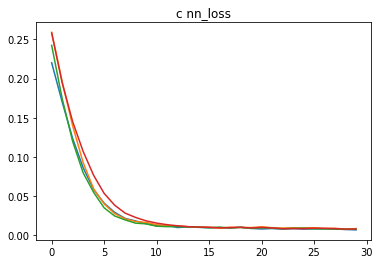

In [43]:
plt.title('c nn_loss')
for i in range(4):
  plt.plot(df_cnn_result[i]['loss'])

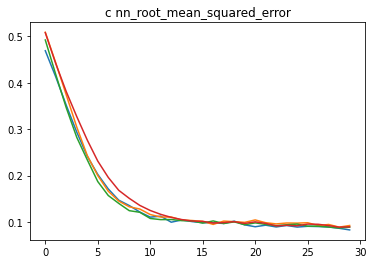

In [44]:
plt.title("c nn_root_mean_squared_error")
for i in range(4):
  plt.plot(df_cnn_result[i]['root_mean_squared_error'])

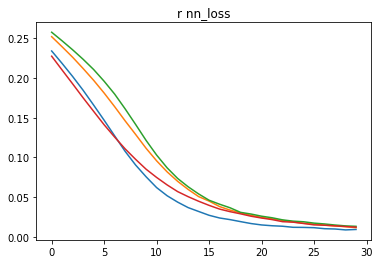

In [45]:
plt.title('r nn_loss')
for i in range(4):
  plt.plot(df_rnn_result[i]['loss'])

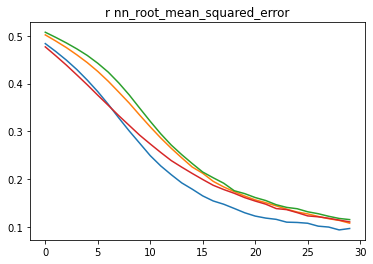

In [46]:
plt.title("r nn_root_mean_squared_error")
for i in range(4):
  plt.plot(df_rnn_result[i]['root_mean_squared_error'])

In [47]:
y_pred_rnn = model_rnn.predict(test_dataset, verbose = True)

13/13 [==============================] - 3s 57ms/step


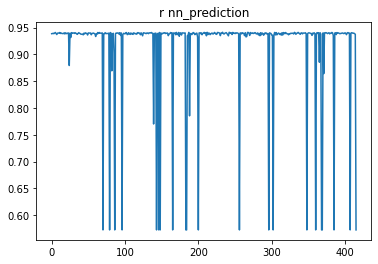

In [48]:
plt.title("r nn_prediction")
plt.plot(y_pred_rnn)

In [49]:
y_pred_cnn = model_cnn.predict(test_dataset, verbose = True)

13/13 [==============================] - 2s 38ms/step


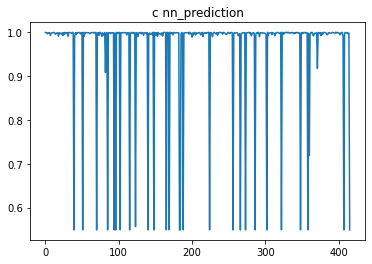

In [50]:
plt.title("c nn_prediction")
plt.plot(y_pred_cnn)

In [120]:
#Get the anomaly prediction
rnn = pd.DataFrame(y_pred_rnn)
rnn.columns = ['Result']
rr = rnn['Result'] > 0.9

cnn = pd.DataFrame(y_pred_cnn)
cnn.columns = ['Result']
cc = rnn['Result'] > 0.8

In [77]:
a = 0
df_testing_label = {}
for i in test_dataset:
  for t in i[1]:
    a+=1
    df_testing_label[a] = int(t.numpy()[0])

In [121]:
#confusion metric
rnn_tn, rnn_fp, rnn_fn, rnn_tp = confusion_matrix(list(df_testing_label.values()), list(rr)).ravel()
cnn_tn, cnn_fp, cnn_fn, cnn_tp = confusion_matrix(list(df_testing_label.values()), list(cc)).ravel()

In [124]:
print("rnn confusion matrix:")
print("tn:",rnn_tn ,"fp:" , rnn_fp,"fn:" , rnn_fn,"tp:" , rnn_tp)
print("cnn confusion matrix:")
print("tn:", cnn_tn, "fp:",  cnn_fp, "fn:", cnn_fn, "tp:", cnn_tp)

rnn confusion matrix:
tn: 16 fp: 233 fn: 11 tp: 156
cnn confusion matrix:
tn: 14 fp: 235 fn: 9 tp: 158
